Pour ce notebook, nous allons regarder une méthode plus complexe que la méthode naïve qui est celle du Q-Learning. \
Le Q-Learning est une méthode d'apprentissage par renforcement qui permet d'apprendre une politique optimale dans un environnement donné. \
Cette méthode utilise un tableau de données appelé Q-Table qui va contenir les valeurs de récompense pour chaque action possible dans chaque état possible. \
L'agent va alors apprendre à choisir l'action qui lui permettra d'obtenir la plus grande récompense possible. \
Pour cela, il va utiliser une fonction de récompense qui va lui permettre de mettre à jour les valeurs de la Q-Table.

## 1. Importation des librairies

In [1]:
import gymnasium as gym # environnement.
import pickle # sauvegarde de notre modèle.
import matplotlib.pyplot as plt # affichage des graphiques.
import numpy as np # manipulation de matrices.
import itertools # manipulation de listes.
import pandas as pd # manipulation de dataframes.
import seaborn as sns # affichage des graphiques.

## 2. Création de l'environnement et de la Q-Table

In [2]:
# Crée l'environnement blackjack.
# natural = True : Si le joueur fait 21 avec deux cartes (As + 10), il obtient une reward plus élevée.
# sab = True : natural est ignoré (reward de 1 même si 21 avec deux cartes) et si le joueur ainsi que le croupier font 21, il s'agira d'un match nul.
env = gym.make('Blackjack-v1', natural=False, sab=True)

# Crée un dictionnaire contenant toutes les combinaisons possibles de l'espace d'observation et d'action.
# obs_act = [(observation[0], observation[1], observation[2], action, 0)] où pour chaque élément, nous prenons toutes les possibilités.
obs_act = list(itertools.product(range(1, env.observation_space[0].n + 1, 1), range(1, env.observation_space[1].n + 1, 1), range(env.observation_space[2].n), range(env.action_space.n)))
Q = dict(zip(obs_act, np.zeros(len(obs_act), dtype=np.float64)))

## 3. Fonction pour le Q-Learning

In [3]:
# Fonction d'exploration/exploitation. (Fonction reprise d'un groupe de projet de cette année).
def creation_epsilon_schedule(total_episodes, epsilon=1.0, epsilon_min=1e-4):
    epsilon_decay = 1- 10 **(int(np.log10(total_episodes))-1)
    x = np.arange(total_episodes)+1
    y = np.full(total_episodes, epsilon)
    y = np.maximum((epsilon_decay**x)*epsilon, epsilon_min)
    return y

# Fonction qui donne l'action qui maximise la Q-Table.
def max_Q(Q, observations):
    if Q[observations[0], observations[1], observations[2], 0] < Q[observations[0], observations[1], observations[2], 1]:
        return 1
    else:
        return 0

# Fonction d'action d'entrainement.
def action_train(Q, observations, epsilon):
    if np.random.uniform(0, 1) < epsilon: # Exploration.
        return env.action_space.sample()
    else: # Exploitation.
        return max_Q(Q, observations)
        

# Fonction d'amélioration de notre Q-Table.
def update_Q_Table(alpha, gamma, Q, reward, first_obs, action, second_obs):
    """
    first_obs[0] : Somme des cartes du joueur avant l'action.
    first_obs[1] : Carte du croupier.
    first_obs[2] : Si on possède un As avant l'action
    action : Action effectuée.
    second_obs[0] : Somme des cartes du joueur après l'action.
    second_obs[1] : Carte du croupier.
    second_obs[2] : Si on possède un As après l'action.
    alpha : Taux d'apprentissage.
    gamma : Facteur d'actualisation
    Définition d'update du Q_Learning trouvé sur : https://en.wikipedia.org/wiki/Q-learning#Algorithm
    """
    Q[first_obs[0], first_obs[1], first_obs[2], action] += alpha * (reward + gamma * max(Q[second_obs[0], second_obs[1], second_obs[2], 0], Q[second_obs[0], second_obs[1], second_obs[2], 1]) - Q[first_obs[0], first_obs[1], first_obs[2], action])

# Fonction d'action de test.
def action_test(Q, observations):
    return max_Q(Q, observations)

## 4. Entrainement de l'agent

In [4]:
# Paramètres pour l'entrainement.
total_train_episodes = 10_000_000
alpha = 0.2
gamma = 0.3
epsilon_schedule = creation_epsilon_schedule(total_train_episodes)

for episode in range(total_train_episodes):

    # Début de notre environnement pour le résoudre.
    first_obs = env.reset()[0]
    action = action_train(Q, first_obs, epsilon_schedule[episode])
    second_obs, reward, done, _, _ = env.step(action)
    update_Q_Table(alpha, gamma, Q, reward, first_obs, action, second_obs)

    # Boucle pour éxécuter plusieurs actions si nécessaire jusqu'à ce que le jeu soit terminé.
    while not done:
        action = action_train(Q, second_obs, epsilon_schedule[episode])
        next_obs, reward, done, _, _ = env.step(action)
        update_Q_Table(alpha, gamma, Q, reward, second_obs, action, next_obs)
        second_obs = next_obs

env.close()

## 5. Visualisation de la Q-Table

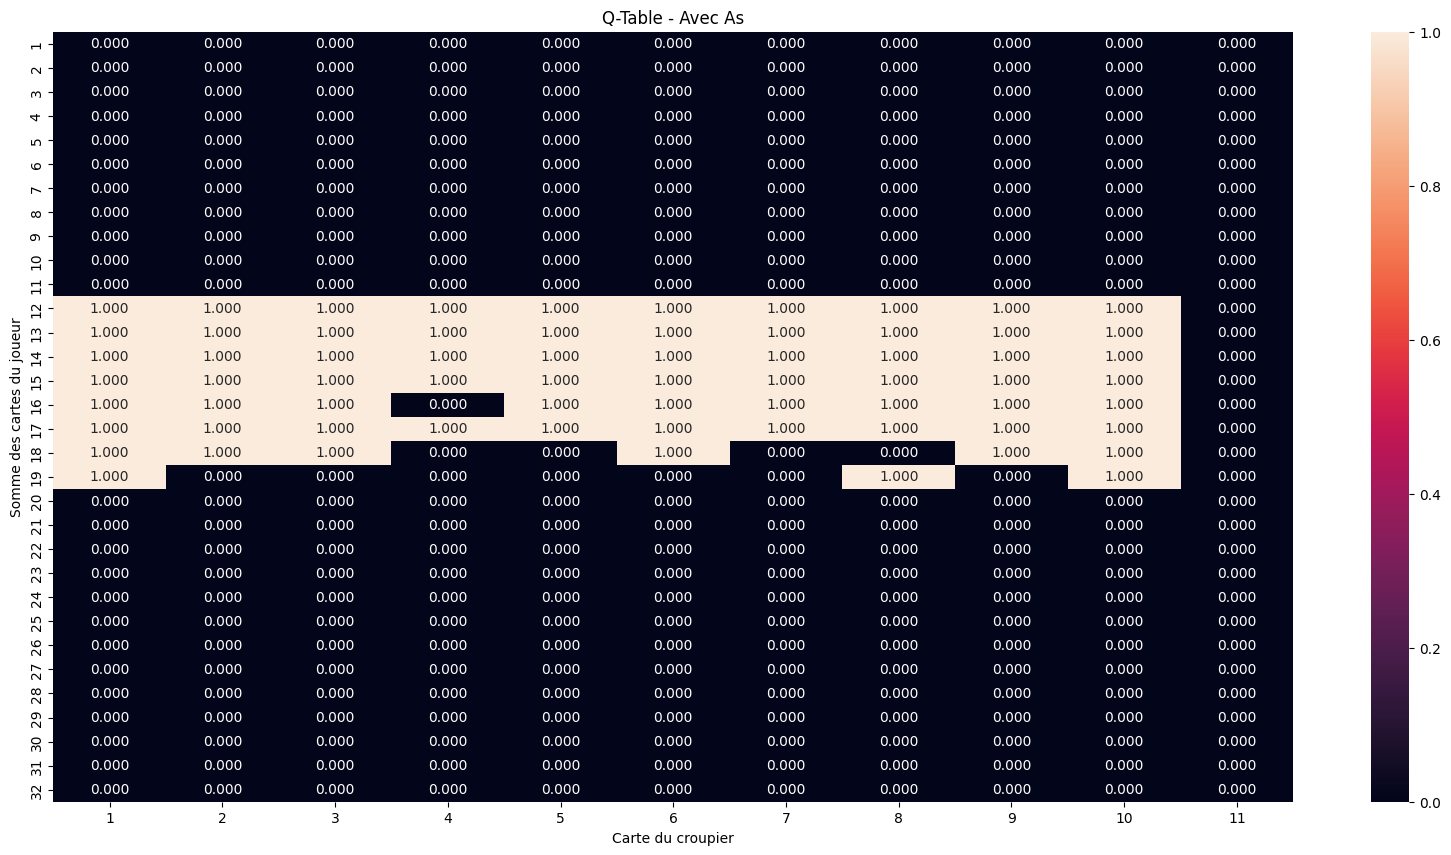

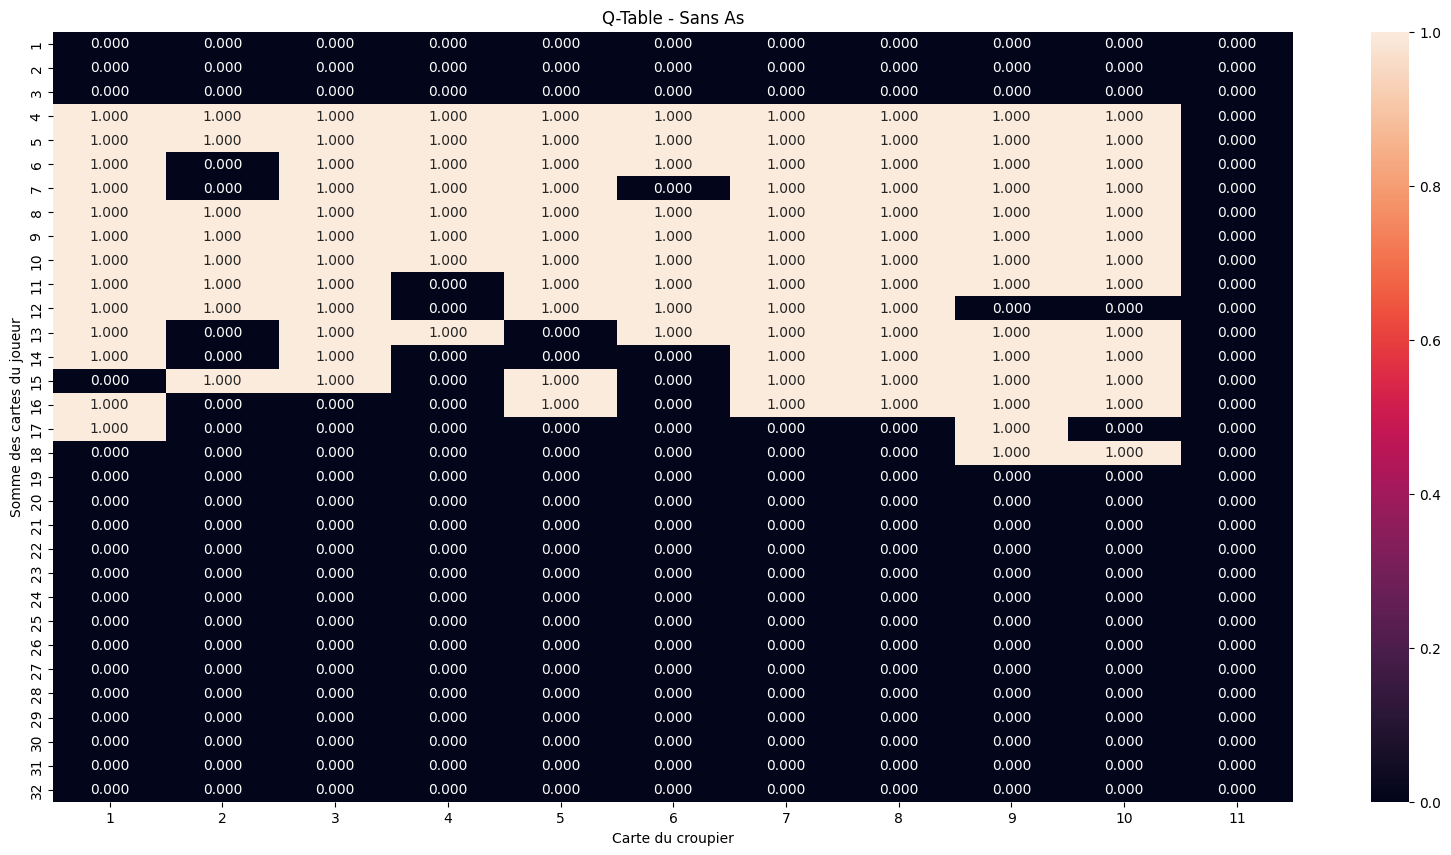

In [5]:
# Visualisation de la Q-table à partir d'une heatmap.
# Dataframe pour la Q-table avec As et sans As.
data_wAce = pd.DataFrame(np.zeros((env.observation_space[0].n, env.observation_space[1].n)), index=range(1, env.observation_space[0].n + 1), columns=range(1, env.observation_space[1].n + 1))
data_nAce = pd.DataFrame(np.zeros((env.observation_space[0].n, env.observation_space[1].n)), index=range(1, env.observation_space[0].n + 1), columns=range(1, env.observation_space[1].n + 1))

# Remplissage des dataframes.
for i in range(1, 12):
    for j in range(1, 33):
        data_wAce[i][j] = max_Q(Q, (j, i, 1))
        data_nAce[i][j] = max_Q(Q, (j, i, 0))

# Plot de la Q-table avec As.
plt.figure(figsize=(20, 10))
sns.heatmap(data_wAce, annot=True, fmt='.3f')
plt.title('Q-Table - Avec As')
plt.xlabel('Carte du croupier')
plt.ylabel('Somme des cartes du joueur')
plt.show()

# Plot de la Q-table sans As.
plt.figure(figsize=(20, 10))
sns.heatmap(data_nAce, annot=True, fmt='.3f')
plt.title('Q-Table - Sans As')
plt.xlabel('Carte du croupier')
plt.ylabel('Somme des cartes du joueur')
plt.show()

## 6. Sauvegarde de la Q-Table

In [6]:
# Permet de sauvegarder notre Q-Table dans un fichier.
with open("QTable.pkl", "wb") as f:
    pickle.dump(Q, f)

## 7. Chargement de la Q-Table

In [7]:
# Permet de charger notre Q-Table depuis un fichier.
with open("QTable.pkl", "rb") as f:
    Q = pickle.load(f)

## 8. Test de notre Agent

In [8]:
# Paramètres pour le test.
total_test_episodes = 1_000_000
total_win = 0
total_loose = 0
total_draw = 0

for episode in range(total_test_episodes):

    # Début de notre environnement pour le résoudre.
    first_obs = env.reset()[0]
    action = action_test(Q, first_obs)
    second_obs, reward, done, _, _ = env.step(action)

    # Boucle pour éxécuter plusieurs actions si nécessaire jusqu'à ce que le jeu soit terminé.
    while not done:
        action = action_test(Q, second_obs)
        next_obs, reward, done, _, _ = env.step(action)

    # Compréhension du résultat du jeu.
    if reward == 1:
        total_win += 1
    elif reward == -1:
        total_loose += 1
    else:
        total_draw += 1

env.close()

## 9. Interprétation des résultats

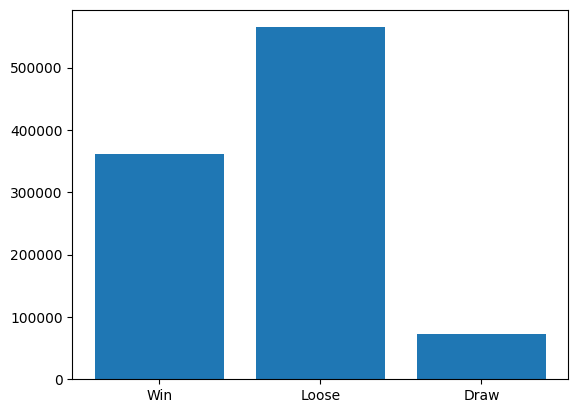

Win : 36.205999999999996 %
Loose : 56.4794 %
Draw : 7.3146 %


In [9]:
# Affichage des résultats.
plt.bar(['Win', 'Loose', 'Draw'], [total_win, total_loose, total_draw])
plt.show()
# Pourcentage des résultats.
print('Win :', total_win / total_test_episodes * 100, '%')
print('Loose :', total_loose / total_test_episodes * 100, '%')
print('Draw :', total_draw / total_test_episodes * 100, '%')